In [34]:
## Load libraries
import pystac_client
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import planetary_computer

In [33]:
import numpy as np

def make_grid(gdf, height, cut=True):
    """
    Return a grid, based on the shape of *gdf* and on a *height* value (in
    units of *gdf*). If cut=False, the grid will not be intersected with *gdf*
    (i.e it makes a grid on the bounding-box of *gdf*).
    Parameters
    ----------
    gdf: GeoDataFrame
        The collection of polygons to be covered by the grid.
    height: Integer
        The dimension (will be used as height and width) of the ceils to create,
        in units of *gdf*.
    cut: Boolean, default True
        Cut the grid to fit the shape of *gdf* (ceil partially covering it will
        be truncated). If False, the returned grid will fit the bounding box
        of *gdf*.
    Returns
    -------
    grid: GeoDataFrame
        A collection of polygons.
    """
    from math import ceil
    from shapely.ops import unary_union
    xmin, ymin = [i.min() for i in gdf.bounds.T.values[:2]]
    xmax, ymax = [i.max() for i in gdf.bounds.T.values[2:]]
    rows = int(ceil((ymax-ymin) / height))
    cols = int(ceil((xmax-xmin) / height))

    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            res_geoms.append((
                (x_left_origin, y_top), (x_right_origin, y_top),
                (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                ))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height
    if cut:
        if all(gdf.eval(
            "geometry.type =='Polygon' or geometry.type =='MultiPolygon'")):
            res = GeoDataFrame(
                geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
                crs=gdf.crs
                ).intersection(unary_union(gdf.geometry))
        else:
            res = GeoDataFrame(
                geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
                crs=gdf.crs
                ).intersection(unary_union(gdf.geometry).convex_hull)
        res = res[res.geometry.type == 'Polygon']
        res.index = [i for i in range(len(res))]
        return GeoDataFrame(geometry=res)

    else:
        return GeoDataFrame(
            index=[i for i in range(len(res_geoms))],
            geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
            crs=gdf.crs
            )


def gridify_data(gdf, height, col_name, cut=True, method=np.mean):
    """
    Gridify a collection of point observations.
    Parameters
    ----------
    gdf: GeoDataFrame
        The collection of polygons to be covered by the grid.
    height: Integer
        The dimension (will be used as height and width) of the ceils to create,
        in units of *gdf*.
    col_name: String
        The name of the column containing the value to use for the grid cells.
    cut: Boolean, default True
        Cut the grid to fit the shape of *gdf* (ceil partially covering it will
        be truncated). If False, the returned grid fit the bounding box of gdf.
    method: Numpy/Pandas function
        The method to aggregate values of points for each cell.
        (like numpy.max, numpy.mean, numpy.mean, numpy.std or numpy.sum)
    Returns
    -------
    grid: GeoDataFrame
        A collection of polygons.
    Example
    -------
    >>> all(gdf.geometry.type == 'Point')  # The function only act on Points
    True
    >>> gdf.time.dtype  # And the value to aggreagate have to be numerical
    dtype('int64')
    >>> grid_data = gridify_data(gdf, 7500, 'time', method=np.min)
    >>> plot_dataframe(grid_data, column='time')
    <matplotlib.axes._subplots.AxesSubplot at 0x7f8336373a20>
    ...
    """
    if not all(gdf.geometry.type == 'Point'):
        raise ValueError("Can only gridify scattered data (Point)")
    if not gdf[col_name].dtype.kind in {'i', 'f'}:
        raise ValueError("Target column have to be a numerical field")

    grid = make_grid(gdf, height, cut)
    grid[col_name] = -1
    index = make_index([i.bounds for i in gdf.geometry])
    for id_cell in range(len(grid)):
        ids_pts = list(index.intersection(
            grid.geometry[id_cell].bounds, objects='raw'))
        if ids_pts:
            res = method(gdf.iloc[ids_pts][col_name])
            grid.loc[id_cell, col_name] = res
    return grid


In [14]:
import dask_gateway

def setup_dask_cluster(max=100):
    cluster = dask_gateway.GatewayCluster()
    client = cluster.get_client()
    cluster.adapt(minimum=2, maximum=max)
    print(cluster.dashboard_link)


In [16]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
)
search = catalog.search(collections=["gbif"])
items = search.get_all_items()
items = {x.id: x for x in items}
item = list(items.values())[0]
item

<Item id=gbif-2022-03-01>

In [17]:
keep_cols= ['gbifid', 'datasetkey', 'occurrenceid', 'kingdom', 'phylum', 'class',\
       'order', 'family', 'genus', 'species','countrycode', 'locality',\
       'stateprovince', 'individualcount','decimallatitude', 'decimallongitude',\
       'coordinateuncertaintyinmeters', 'coordinateprecision', 'elevation',\
       'elevationaccuracy', 'depth', 'depthaccuracy', 'eventdate', 'day',
       'month', 'year', 'taxonkey', 'basisofrecord', 'issue', 'occurrencestatus']


In [18]:
min_cols = ['species','genus','countrycode','decimallatitude', 'decimallongitude','basisofrecord', 'issue', 'occurrencestatus']

Load a dask frame with the pointer to the GBIF data

In [19]:
signed_asset = planetary_computer.sign(item).assets["data"]

ddf = dd.read_parquet(
    signed_asset.href,
    columns = min_cols,
    storage_options=signed_asset.extra_fields["table:storage_options"],
    dataset={"require_extension": None},
)
ddf.npartitions

1105

In [20]:
ddf.head()

,species,genus,countrycode,decimallatitude,decimallongitude,basisofrecord,issue,occurrencestatus
0,Cymbopogon bombycinus,Cymbopogon,AU,-23.8500,151.2500,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT
1,Eremophila elderi,Eremophila,AU,-23.3167,130.3667,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT
2,Carex chlorantha,Carex,AU,-37.7000,148.4500,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT
3,Philonotis tenuis,Philonotis,AU,-35.8667,148.5000,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT
4,Senecio pinnatifolius,Senecio,AU,-37.5667,149.7500,PRESERVED_SPECIMEN,"[INSTITUTION_MATCH_FUZZY, COLLECTION_MATCH_FUZZY]",PRESENT


In [15]:
setup_dask_cluster()

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.449139108e374185ba480985de0cef1b/status


## Filter GBIF data
Possibbasisofrecordilters:
- Countrycode (CR)
- coordinateuncertaintyinmeters (< some number like 1000 or 10000m)
- dateidentified (some minimum date)
- Kingdom/Phylum/class/order/..
- Remove fossils (basisofrecord != 'FOSSIL_SPECIMEN') [Basis of Record explainer](https://gbif.github.io/gbif-api/apidocs/org/gbif/api/vocabulary/BasisOfRecord.html)
- occurrencestatus == 'PRESENT'

Maybe:
- taxonkey = 212 for all birds, etc


The Parquet file schema is described below.  Most field names correspond to [terms from the Darwin Core standard](https://dwc.tdwg.org/terms/), and have been interpreted by GBIF's systems to align taxonomy, location, dates etc.
Additional information may be retrived using the [GBIF API](https://www.gbif.org/developer/summary).

|              Field¹              |     Type      | Nullable | Description                   |
|----------------------------------|---------------|----------|-------------------------------|
| gbifid                           | BigInt        | N        | GBIF's identifier for the occurrence |
| datasetkey                       | String (UUID) | N        | GBIF's UUID for the [dataset](https://www.gbif.org/developer/registry#datasets) containing this occurrence |
| publishingorgkey                 | String (UUID) | N        | GBIF's UUID for the [organization](https://www.gbif.org/developer/registry#organizations) publishing this occurrence. |
| occurrencestatus                 | String        | N        | See [dwc:occurrenceStatus](https://dwc.tdwg.org/terms/#occurrenceStatus). Either the value `PRESENT` or `ABSENT`.  Many users will wish to filter for `PRESENT` data. |
| basisofrecord                    | String        | N        | See [dwc:basisOfRecord](https://dwc.tdwg.org/terms/#basisOfRecord).  One of `PRESERVED_SPECIMEN`, `FOSSIL_SPECIMEN`, `LIVING_SPECIMEN`, `OBSERVATION`, `HUMAN_OBSERVATION`, `MACHINE_OBSERVATION`, `MATERIAL_SAMPLE`, `LITERATURE`, `UNKNOWN`. |
| kingdom                          | String        | Y        | See [dwc:kingdom](https://dwc.tdwg.org/terms/#kingdom).  This field has been aligned with the [GBIF backbone taxonomy](https://doi.org/10.15468/39omei). |
| phylum                           | String        | Y        | See [dwc:phylum](https://dwc.tdwg.org/terms/#phylum).  This field has been aligned with the GBIF backbone taxonomy. |
| class                            | String        | Y        | See [dwc:class](https://dwc.tdwg.org/terms/#class).  This field has been aligned with the GBIF backbone taxonomy. |
| order                            | String        | Y        | See [dwc:order](https://dwc.tdwg.org/terms/#order).  This field has been aligned with the GBIF backbone taxonomy. |
| family                           | String        | Y        | See [dwc:family](https://dwc.tdwg.org/terms/#family).  This field has been aligned with the GBIF backbone taxonomy. |
| genus                            | String        | Y        | See [dwc:genus](https://dwc.tdwg.org/terms/#genus).  This field has been aligned with the GBIF backbone taxonomy. |
| species                          | String        | Y        | See [dwc:species](https://dwc.tdwg.org/terms/#species).  This field has been aligned with the GBIF backbone taxonomy. |
| infraspecificepithet             | String        | Y        | See [dwc:infraspecificEpithet](https://dwc.tdwg.org/terms/#infraspecificEpithet).  This field has been aligned with the GBIF backbone taxonomy. |
| taxonrank                        | String        | Y        | See [dwc:taxonRank](https://dwc.tdwg.org/terms/#taxonRank).  This field has been aligned with the GBIF backbone taxonomy. |
| scientificname                   | String        | Y        | See [dwc:scientificName](https://dwc.tdwg.org/terms/#scientificName).  This field has been aligned with the GBIF backbone taxonomy. |
| verbatimscientificname           | String        | Y        | The scientific name as provided by the data publisher |
| verbatimscientificnameauthorship | String        | Y        | The scientific name authorship provided by the data publisher. |
| taxonkey                         | Integer       | Y        | The numeric identifier for the [taxon](https://www.gbif.org/developer/species#nameUsages) in GBIF's backbone taxonomy corresponding to `scientificname`. |
| specieskey                       | Integer       | Y        | The numeric identifier for the taxon in GBIF's backbone taxonomy corresponding to `species`. |
| typestatus                       | String        | Y        | See [dwc:typeStatus](https://dwc.tdwg.org/terms/#typeStatus). |
| countrycode                      | String        | Y        | See [dwc:countryCode](https://dwc.tdwg.org/terms/#countryCode).  GBIF's interpretation has set this to an ISO 3166-2 code. |
| locality                         | String        | Y        | See [dwc:locality](https://dwc.tdwg.org/terms/#locality). |
| stateprovince                    | String        | Y        | See [dwc:stateProvince](https://dwc.tdwg.org/terms/#stateProvince). |
| decimallatitude                  | Double        | Y²       | See [dwc:decimalLatitude](https://dwc.tdwg.org/terms/#decimalLatitude).  GBIF's interpretation has normalized this to a WGS84 coordinate. |
| decimallongitude                 | Double        | Y²       | See [dwc:decimalLongitude](https://dwc.tdwg.org/terms/#decimalLongitude).  GBIF's interpretation has normalized this to a WGS84 coordinate. |
| coordinateuncertaintyinmeters    | Double        | Y        | See [dwc:coordinateUncertaintyInMeters](https://dwc.tdwg.org/terms/#coordinateUncertaintyInMeters). |
| coordinateprecision              | Double        | Y        | See [dwc:coordinatePrecision](https://dwc.tdwg.org/terms/#coordinatePrecision). |
| elevation                        | Double        | Y        | See [dwc:elevation](https://dwc.tdwg.org/terms/#elevation).  If provided by the data publisher, GBIF's interpretation has normalized this value to metres. |
| elevationaccuracy                | Double        | Y        | See [dwc:elevationAccuracy](https://dwc.tdwg.org/terms/#elevationAccuracy).  If provided by the data publisher, GBIF's interpretation has normalized this value to metres. |
| depth                            | Double        | Y        | See [dwc:depth](https://dwc.tdwg.org/terms/#depth).  If provided by the data publisher, GBIF's interpretation has normalized this value to metres. |
| depthaccuracy                    | Double        | Y        | See [dwc:depthAccuracy](https://dwc.tdwg.org/terms/#depthAccuracy).  If provided by the data publisher, GBIF's interpretation has normalized this value to metres. |
| eventdate                        | String        | Y        | See [dwc:eventDate](https://dwc.tdwg.org/terms/#eventDate).  GBIF's interpretation has normalized this value to an ISO 8601 date with a local time. |
| year                             | Integer       | Y        | See [dwc:year](https://dwc.tdwg.org/terms/#year). |
| month                            | Integer       | Y        | See [dwc:month](https://dwc.tdwg.org/terms/#month). |
| day                              | Integer       | Y        | See [dwc:day](https://dwc.tdwg.org/terms/#day). |
| individualcount                  | Integer       | Y        | See [dwc:individualCount](https://dwc.tdwg.org/terms/#individualCount). |
| establishmentmeans               | String        | Y        | See [dwc:establishmentMeans](https://dwc.tdwg.org/terms/#establishmentMeans). |
| occurrenceid                     | String        | Y³       | See [dwc:occurrenceID](https://dwc.tdwg.org/terms/#occurrenceID). |
| institutioncode                  | String        | Y³       | See [dwc:institutionCode](https://dwc.tdwg.org/terms/#institutionCode). |
| collectioncode                   | String        | Y³       | See [dwc:collectionCode](https://dwc.tdwg.org/terms/#collectionCode). |
| catalognumber                    | String        | Y³       | See [dwc:catalogNumber](https://dwc.tdwg.org/terms/#catalogNumber). |
| recordnumber                     | String        | Y        | See [dwc:recordNumber](https://dwc.tdwg.org/terms/#recordNumber). |
| recordedby                       | String        | Y        | See [dwc:recordedBy](https://dwc.tdwg.org/terms/#recordedBy). |
| identifiedby                     | String        | Y        | See [dwc:identifiedBy](https://dwc.tdwg.org/terms/#identifiedBy). |
| dateidentified                   | String        | Y        | See [dwc:dateIdentified](https://dwc.tdwg.org/terms/#dateIdentified). An ISO 8601 date. |
| mediatype                        | String array  | N⁴       | See [dwc:mediaType](https://dwc.tdwg.org/terms/#mediaType).  May contain `StillImage`, `MovingImage` or `Sound` (from [enumeration](http://api.gbif.org/v1/enumeration/basic/MediaType), detailing whether the occurrence has this media available. |
| issue                            | String array  | N⁴       | A list of [issues](https://gbif.github.io/gbif-api/apidocs/org/gbif/api/vocabulary/OccurrenceIssue.html) encountered by GBIF in processing this record. More details are available on these issues and flags in [this blog post](https://data-blog.gbif.org/post/issues-and-flags/).|
| license                          | String        | N        | See [dwc:license](https://dwc.tdwg.org/terms/#license). Either [`CC0_1_0`](https://creativecommons.org/publicdomain/zero/1.0/) or [`CC_BY_4_0`](https://creativecommons.org/licenses/by/4.0/).  `CC_BY_NC_4_0` records are not present in this snapshot. |
| rightsholder                     | String        | Y        | See [dwc:rightsHolder](https://dwc.tdwg.org/terms/#rightsHolder). |
| lastinterpreted                  | String        | N        | The ISO 8601 date when the record was last processed by GBIF. Data are reprocessed for several reasons, including changes to the backbone taxonomy, so this date is not necessarily the date the occurrence record last changed. |

¹ Field names are lower case, but in later snapshots this may change to camelCase, for consistency with Darwin Core and the GBIF API.

² Occurrences without coordinates are excluded from this snapshot, although this may change in the future.

³ Either `occurrenceID`, or `institutionCode` + `collectionCode` + `catalogNumber`, or both, will be present on every record.

⁴ The array may be empty.


In [21]:
gbif_cr = ddf.loc[ddf.countrycode == 'CR']

In [22]:
gbif_cr = gbif_cr.loc[gbif_cr.basisofrecord != 'FOSSIL_SPECIMEN']
gbif_cr = gbif_cr.loc[gbif_cr.occurrencestatus == 'PRESENT']


In [23]:
len(gbif_cr.index)

17346233

### Drop Columns

Consider keeping ['issue'](https://gbif.github.io/gbif-api/apidocs/org/gbif/api/vocabulary/OccurrenceIssue.html) for later filtering

In [24]:
gbif_cr_min = gbif_cr.drop(['basisofrecord','occurrencestatus','issue'], axis=1)

In [25]:
gbif_cr_min.columns

Index(['species', 'genus', 'countrycode', 'decimallatitude',
       'decimallongitude'],
      dtype='object')

In [26]:
#sanity check
df = gbif_cr_min.drop(['genus','decimallatitude','decimallongitude'], axis=1)
species_per_country = df.groupby("countrycode").species.nunique()
species_per_country

Dask Series Structure:
npartitions=1
    int64
      ...
Name: species, dtype: int64
Dask Name: series-groupby-nunique-agg, 14526 tasks

In [27]:
species_per_country_df = species_per_country.compute()

In [28]:
species_per_country_df

countrycode
CR    45157
Name: species, dtype: int64

------------------------------------------------
Convert dask df directly to dask-geopandas df


In [31]:
import dask_geopandas as gpdd
gbif_cr_min["geometry"] = gpd.points_from_xy(gbif_cr_min['decimallongitude'],gbif_cr_min['decimallatitude'])
ggbif_cr_min_gpd = dask_geopandas.from_dask_dataframe(gbif_cr_min, geometry="geometry", crs = "EPSG:4326")


TypeError: Column assignment doesn't support type geopandas.array.GeometryArray

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent ca

## Let's convert our gbif_cr to a geopandas frame

CRS is the geolocation in the WGS84 format (EPSG 4326)

In [26]:
gbif_cr_df = gbif_cr_min.compute()

In [ ]:
#1. Import species data into a GeoDataFrame
cr_gdf = gpd.GeoDataFrame(gbif_cr_df, 
              geometry=gpd.points_from_xy(gbif_cr_min['decimallongitude'], 
                                          gbif_cr_min['decimallatitude']), crs = "EPSG:4326")

In [31]:
cr_species = cr_gdf.drop(columns=['countrycode','decimallatitude','decimallongitude']).reset_index()

In [32]:
cr_species

,index,species,genus,geometry
0,288,None,Theobroma,POINT (-84.60917 10.02778)
1,4173,None,Lobaria,POINT (-83.08330 8.91670)
2,19531,None,Begonia,POINT (-83.95000 9.93333)
3,24401,Chaenotheca ferruginea,Chaenotheca,POINT (-83.85000 9.95000)
4,29074,None,Cladonia,POINT (-83.91670 9.68330)
...,...,...,...,...
17346228,53286,Vibrissina robertwellsi,Vibrissina,POINT (-85.52700 11.03000)
17346229,53287,Vibrissina robertwellsi,Vibrissina,POINT (-85.61870 10.83760)
17346230,1049418,Litoleptis tico,Litoleptis,POINT (-84.00800 10.04700)
17346231,1369938,Hydrophis platurus,Hydrophis,POINT (-85.35485 10.30401)


In [10]:
countries = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")
cr_vec_hires = countries[countries.ISO_A2 == 'CR']
cr_vec_hires

,ADMIN,ISO_A3,ISO_A2,geometry
53,Costa Rica,CRI,CR,"MULTIPOLYGON (((-87.09903 5.51602, -87.11767 5..."


**Add Shravan's code for high res polygons here**

Lets try out dask_geopandas

In [12]:
import dask_geopandas as gpdd
cr_species_ddf = gpdd.from_geopandas(cr_species, npartitions=100)



NameError: name 'cr_species' is not defined

In [41]:
slice3 = cr_species_ddf.partitions[3].compute()

<AxesSubplot:>

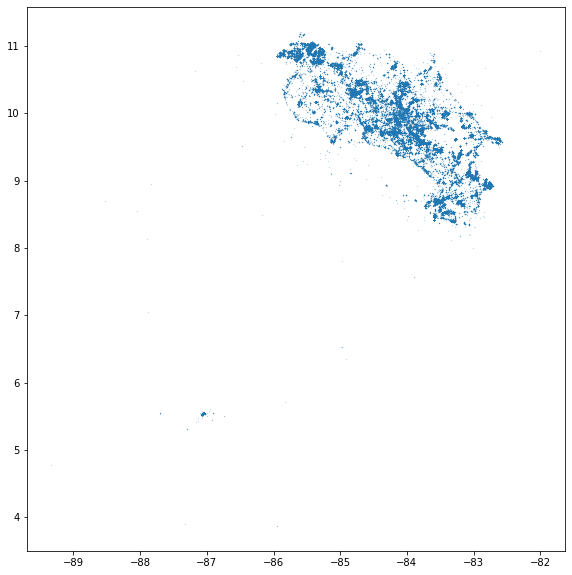

In [42]:
slice3.plot(markersize=0.01, figsize=(10,10))

### Clip to terrestrial CR

In [45]:
cr_terr = gpdd.clip(cr_species_ddf,cr_vec)
cr_terr

,index,species,genus,geometry
npartitions=100,,,,
0,int64,object,object,geometry
173463,...,...,...,...
...,...,...,...,...
17172837,...,...,...,...
17346232,...,...,...,...


<AxesSubplot:>

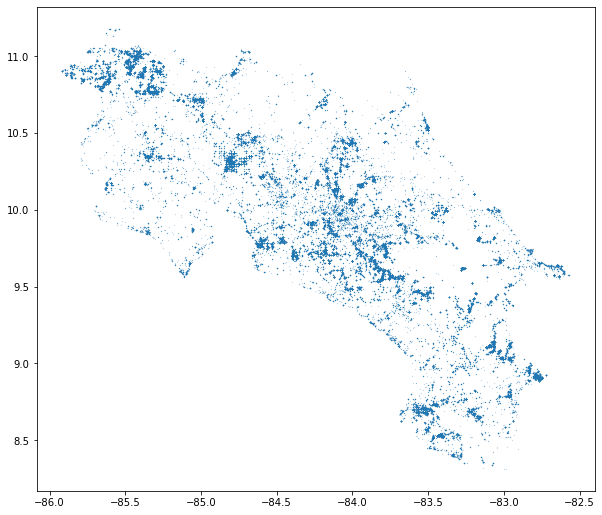

In [46]:
slice3 = cr_terr.partitions[3].compute()
# slice3.plot(markersize=0.01, figsize=(10,10))

In [98]:
slice3_clean = slice3.dropna(subset=['species'])

(-86.11150188876267, -82.37641979646257, 8.075423417590205, 11.366723812297376)

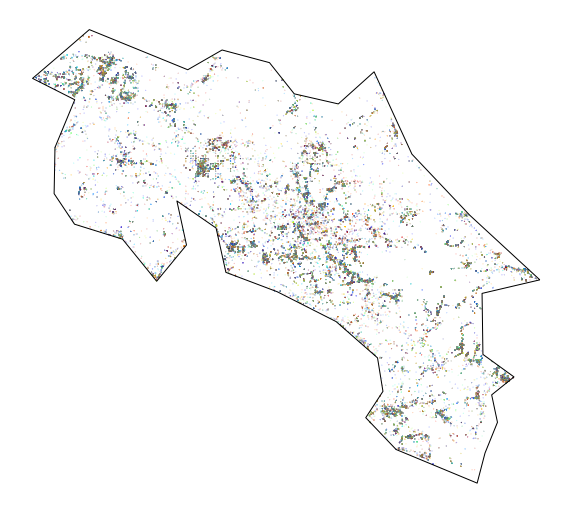

In [102]:
ax = slice3_clean.plot(markersize=0.01, figsize=(10,10), column = 'species', cmap='jet')
cr_vec.to_crs(slice3.crs).plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

,index,species,genus,geometry
npartitions=100,,,,
0,int64,object,object,geometry
173463,...,...,...,...
...,...,...,...,...
17172837,...,...,...,...
17346232,...,...,...,...


[-85.94172543002176, 8.225027980985985, -82.54619625520348, 11.217119248901597]